In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
DATA_DIR = '/kaggle/working/data/CamVid/'

Cloning into './data'...


In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

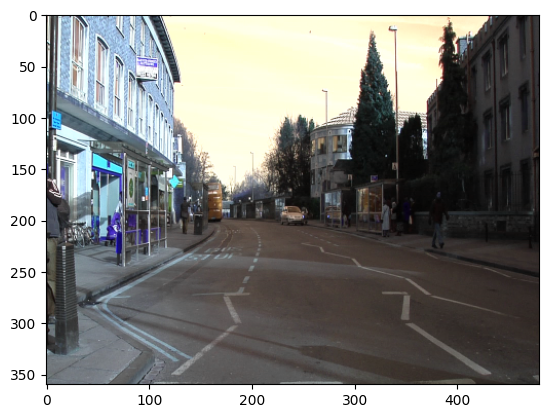

In [5]:
temp_img = cv2.imread("/kaggle/working/data/CamVid/train/0016E5_08550.png") #3 channels / spectral bands
plt.imshow(temp_img[:,:,:]) 

Labels are:  [ 0  1  2  3  4  5  6  7  8  9 11]  and the counts are:  [28065 38394  3959 54465 12351 15544   901  4415   835  3109 10762]
(360, 480) (360, 480, 3)


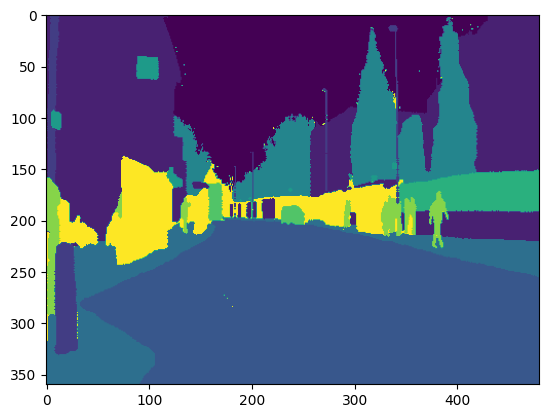

In [6]:
temp_mask = cv2.imread("/kaggle/working/data/CamVid/trainannot/0016E5_08550.png") #3 channels but all same.
temp_mask_gray = cv2.cvtColor(temp_mask, cv2.COLOR_BGR2GRAY)
sf = 1
# Resize the mask
scaled_mask = cv2.resize(temp_mask_gray, None, fx=sf, fy=sf, interpolation=cv2.INTER_AREA)
plt.imshow(scaled_mask)
labels, count = np.unique(scaled_mask, return_counts=True)
print("Labels are: ", labels, " and the counts are: ", count)
print(scaled_mask.shape,temp_img.shape )

In [7]:
unique_elements = np.unique(scaled_mask)
unique_elements

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11], dtype=uint8)

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [86]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
            
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

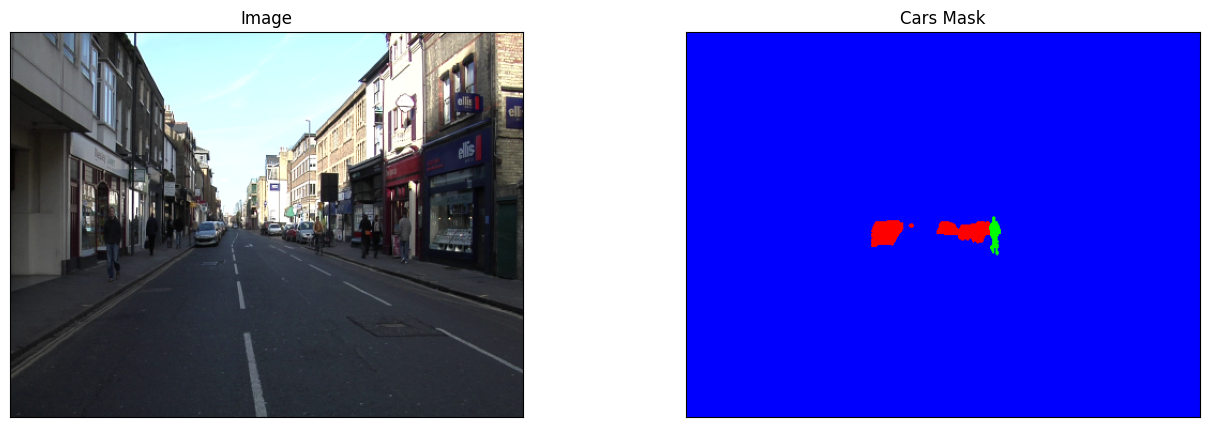

In [87]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'bicyclist'])

image, mask = dataset[20] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [12]:
!pip install -U albumentations[imgaug]

In [88]:
import albumentations as albu
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

#         albu.IAAAdditiveGaussianNoise(p=0.2),
#         albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
#                 albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

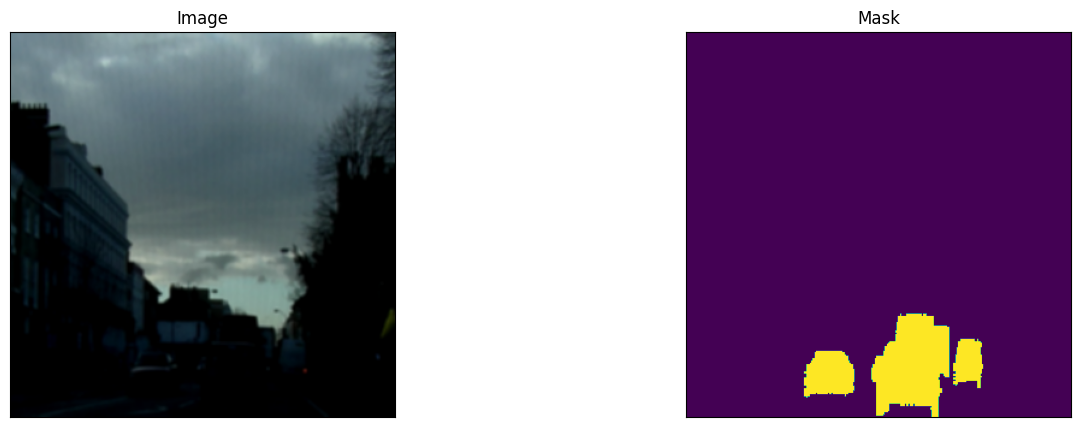

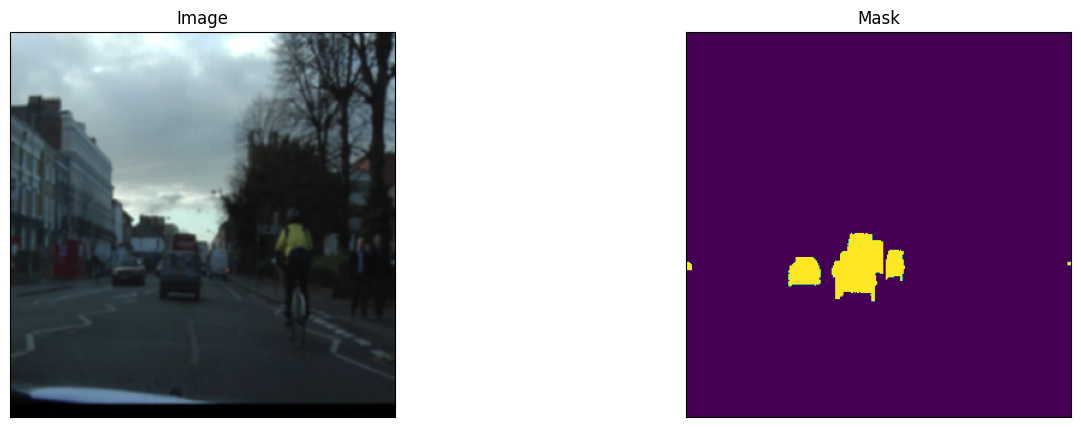

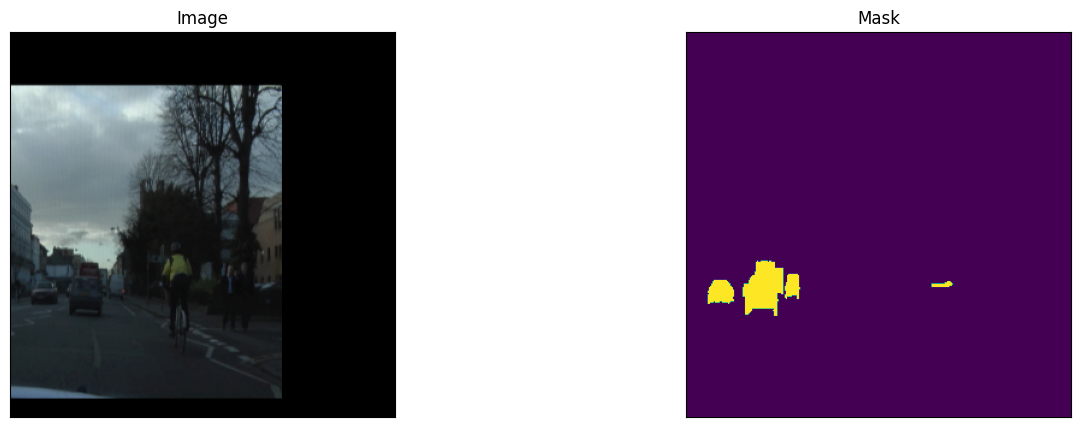

In [90]:
#### Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation = get_training_augmentation(),
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [15]:
!pip install -U segmentation-models-pytorch --user 

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.9 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [39]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [43]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [44]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


In [45]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
import segmentation_models_pytorch.utils as sp
loss = smp.losses.DiceLoss( mode = "binary")
loss.__name__ = 'Dice_loss'
metrics = [
    sp.metrics.IoU(threshold=0.5), sp.metrics.Accuracy(threshold=0.5), sp.metrics.Fscore(threshold=0.5) 
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [46]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [47]:
max_score = 0

for i in range(0, 30):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 101/101 [00:02<00:00, 42.10it/s, Dice_loss - 0.957, iou_score - 0.219, accuracy - 0.9557, fscore - 0.3345] 
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:02<00:00, 42.73it/s, Dice_loss - 0.9568, iou_score - 0.3201, accuracy - 0.9761, fscore - 0.4581]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:02<00:00, 44.10it/s, Dice_loss - 0.9566, iou_score - 0.3945, accuracy - 0.9827, fscore - 0.5481]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:02<00:00, 43.04it/s, Dice_loss - 0.9565, iou_score - 0.4101, accuracy - 0.9845, fscore - 0.5599]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:02<00:00, 43.34it/s, Dice_loss - 0.9565, iou_score - 0.4083, accuracy - 0.9847, fscore - 0.5599]

Epoch: 5
valid: 100%|██████████| 101/101 [00:02<00:00, 43.85it/s, Dice_loss - 0.9565, iou_score - 0.3711, accuracy - 0.9812, fscore - 0.5164]

Epoch: 6
valid: 100%|██████████| 101/101 [00:02<00:00, 43.36it/s, Dice_loss - 0.9565, iou_

In [48]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [49]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [50]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:07<00:00, 30.14it/s, Dice_loss - 0.8725, iou_score - 0.6079, accuracy - 0.9902, fscore - 0.7225]


In [52]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

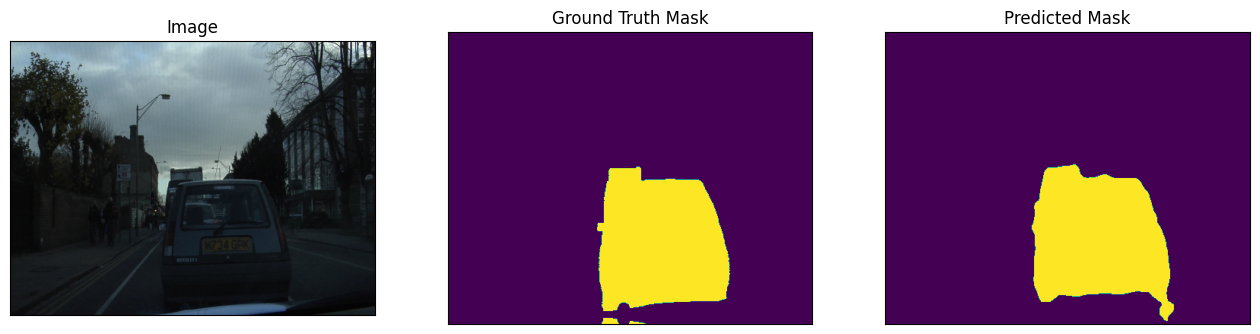

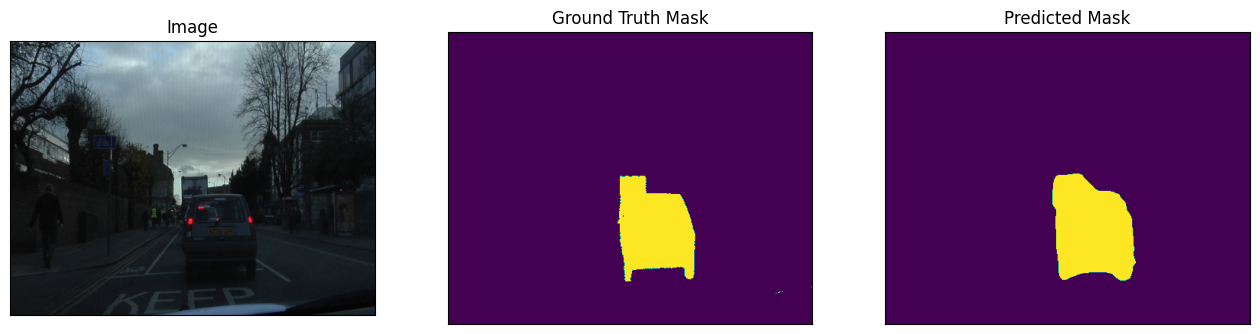

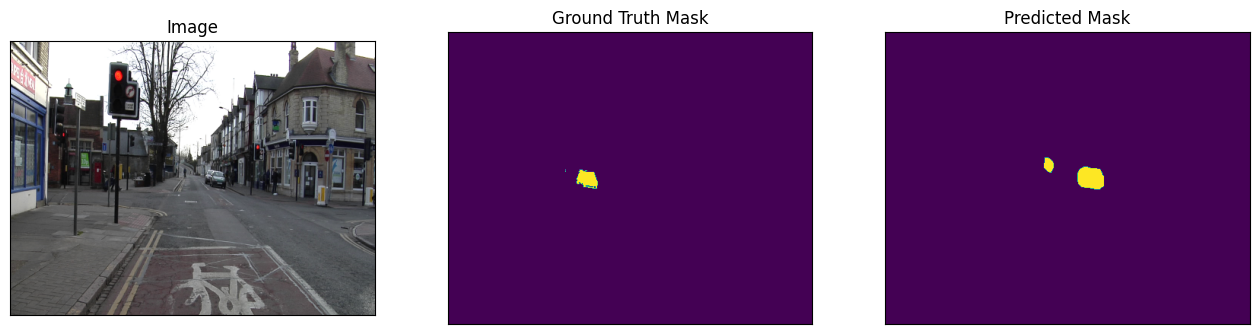

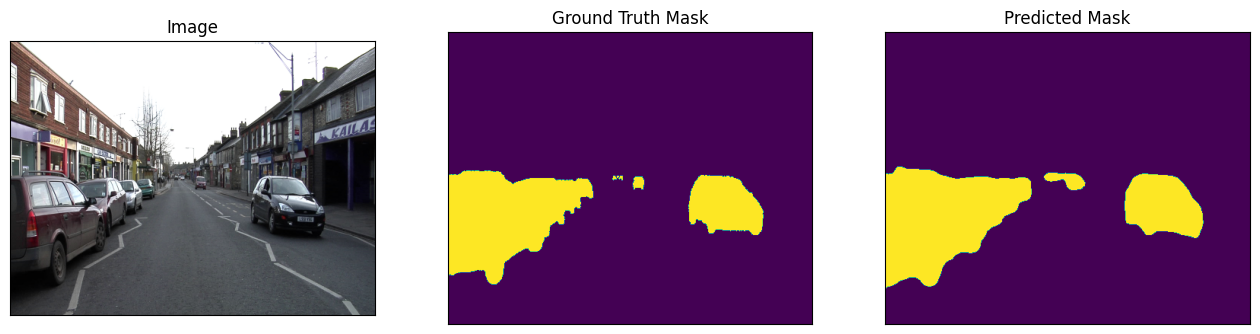

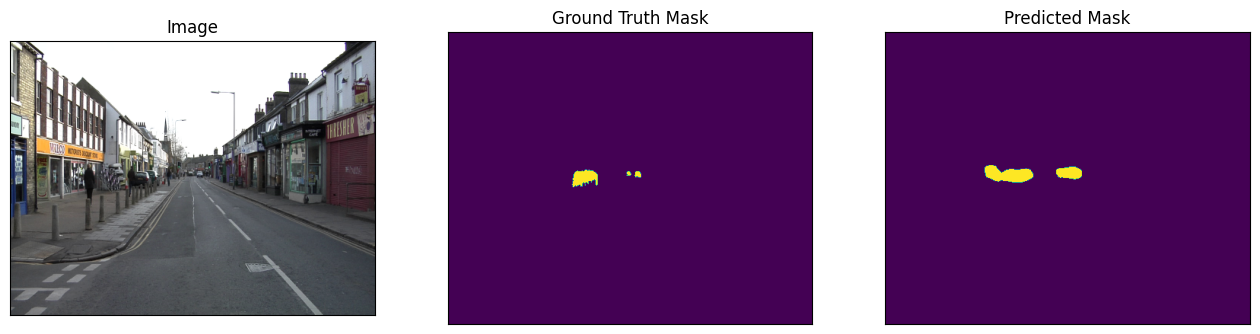

In [54]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )